In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()

In [19]:
def compute_ema(data, alpha=0.1):
    ema = []
    ema.append(data[0])  # start with the first data point
    ema.append(data[1])

    for i in range(2, len(data)):
        next_ema = (1 - alpha) * ema[-1] + alpha * data[i]
        ema.append(next_ema)
    
    return np.array(ema)

def plot_training_curves(sorted_data, xlim, ylim, data, metric, save_name=None):
    """
    Plot performance vs. time
    """
    plt.figure(figsize=(10, 6))

    #x = np.arange(len(methods)) # todelete?
    colors = plt.cm.get_cmap('tab10', len(sorted_data)+1)
    line_styles = ['-', '-', '-', '-', '-', '-']
    line_widths = [2]*6
    #markers = ['o', 's', '^', 'x']
    #alphas = [0.8, 1.0, 0.8, 0.7]

    for i, method in enumerate(sorted_data):

        lengths = [len(result['time']) for result in sorted_data[method]]
        cutoff = min(lengths)
        print(lengths, cutoff, method)
        times = np.array([result['time'][:cutoff] for result in sorted_data[method]])
        losses = np.array([result[metric][:cutoff] for result in sorted_data[method]])
        
        # debug
        #for result in sorted_data[method]:
        #    print(len(result['time']))
        
        #print(times.shape, times[:, :10])
        #print(losses.shape, losses[:, :10])

        # compute stdev
        time = np.mean(times, axis=0)
        mean_losses = np.mean(losses,axis=0)

        #print(mean_losses.shape, mean_losses[:5])
        mean_losses = compute_ema(mean_losses)
        #print(mean_losses.shape, mean_losses[:5])

        std_losses = np.std(losses,axis=0)
        std_min = mean_losses - std_losses
        std_max = mean_losses + std_losses

        # Calculate cumulative time
        cumulative_time = np.nancumsum(time) / 60
        plt.plot(cumulative_time, mean_losses, color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i], alpha=.9, label=method)
        plt.fill_between(cumulative_time, std_min, std_max, color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i],label='_hidden',   alpha=0.3)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=14)
    plt.grid(True)

    plt.xlabel('Time (minutes)', fontsize=16)
    if metric == '128_h1':
        plt.ylabel('H1 Loss', fontsize=16)
        plt.title('H1 Loss vs. Wallclock Time, {}'.format(data), fontsize=20)
    elif metric == '128_l2':
        plt.ylabel('L2 Loss', fontsize=16)
        plt.title('L2 Loss vs. Wallclock Time, {}'.format(data), fontsize=20)
    if save_name:
        plt.savefig('error_vs_time_h1_{}.pdf'.format(data.split(" ")), format='pdf')

    plt.show()

# Plot Darcy results

In [3]:
# Darcy, 8layer, half/sched/full
project_name = "crwhite/lowprecision"
ids = {
    'u2b09bie', # full-seed-1
    'u2aq6re1', # full-seed-2
    '407u1qcb', # full-seed-3
    '3d43rgop', # half-seed-1
    'toobdug0', # half-seed-2
    '2kpjgs9j', # half-seed-3
    'kumtgefy', # sched-seed-1
    'm7qvi4s3', # sched-seed-2
    'o0e8zmo7', # sched-seed-3
}

raw_data = {}
i = 0
for exp_id in ids:
    run = wandb.Api().run(f"{project_name}/{exp_id}")
    raw_data[exp_id] = run

sorted_data = {'half': [], 'full': [], 'schedule': []}

for _, run in raw_data.items():
    if run.config['opt']['precision_schedule']:
        precision = 'schedule'
    elif run.config['tfno2d']['half_prec_fourier']:
        precision = 'half'
    else:
        precision = 'full'
    sorted_data[precision].append(run.history())

[365, 365, 365] 365 half
365
365
365
[300, 300, 300] 300 full
300
300
300
[345, 345, 345] 345 schedule
345
345
345


/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_2056/1601433031.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_data)+1)


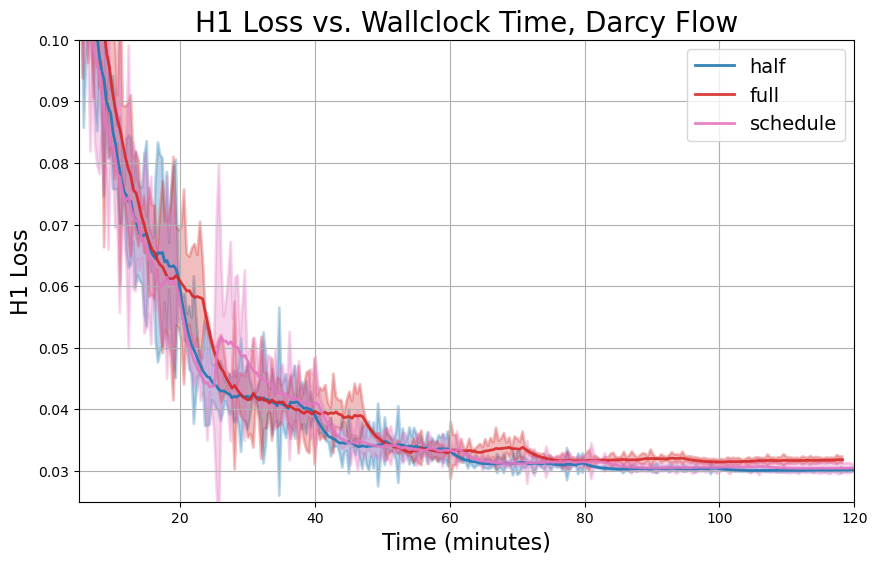

[365, 365, 365] 365 half
365
365
365
[300, 300, 300] 300 full
300
300
300
[345, 345, 345] 345 schedule
345
345
345


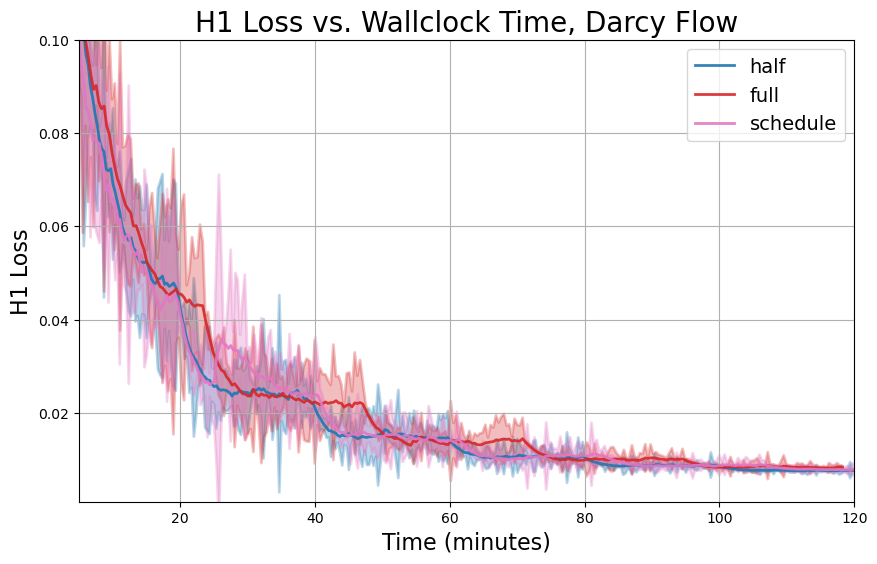

In [6]:
plot_training_curves(sorted_data, data='Darcy Flow', xlim=[5, 120], ylim=[.025,.1], metric='128_h1')
plot_training_curves(sorted_data, data='Darcy Flow', xlim=[5, 120], ylim=[.001,.1], metric='128_l2')

## Plot Navier Stokes

In [25]:
# navier stokes, 8layer, half/sched/full

project_name = "crwhite/lowprecision"
ids = {
    '5wem45py', # full-seed-1
    't8049sy5', # full-seed-2
    'n0ls1wit', # full-seed-3
    '46q3wca6', # half-seed-1
    'kbdfc25g', # half-seed-2
    #'7l3nmpi9', # half-seed-3 # not done running
    'kcx20sr7', # sched-seed-1
    'q5rz9qfp', # sched-seed-2
    '5w5qws2x', # sched-seed-3
}


raw_data = {}
i = 0
for exp_id in ids:
    run = wandb.Api(timeout=500).run(f"{project_name}/{exp_id}")
    raw_data[exp_id] = run

sorted_data = {'half': [], 'full': [], 'schedule': []}

for _, run in raw_data.items():
    if run.config['opt']['precision_schedule']:
        precision = 'schedule'
    elif run.config['tfno2d']['half_prec_fourier']:
        precision = 'half'
    else:
        precision = 'full'
    result = run.history(samples=800)   
    print(len(result['time']), precision)
    sorted_data[precision].append(result)


770 half
500 full
770 half
632 schedule
653 schedule
500 full
750 schedule
500 full


[770, 770] 770 half
[500, 500, 500] 500 full
[632, 653, 750] 632 schedule


/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_2056/2623083440.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_data)+1)


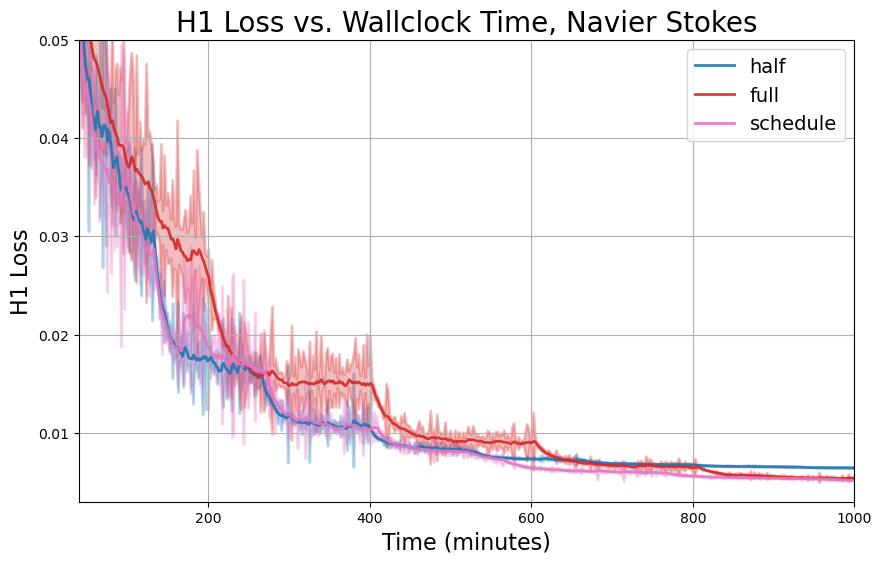

[770, 770] 770 half
[500, 500, 500] 500 full
[632, 653, 750] 632 schedule


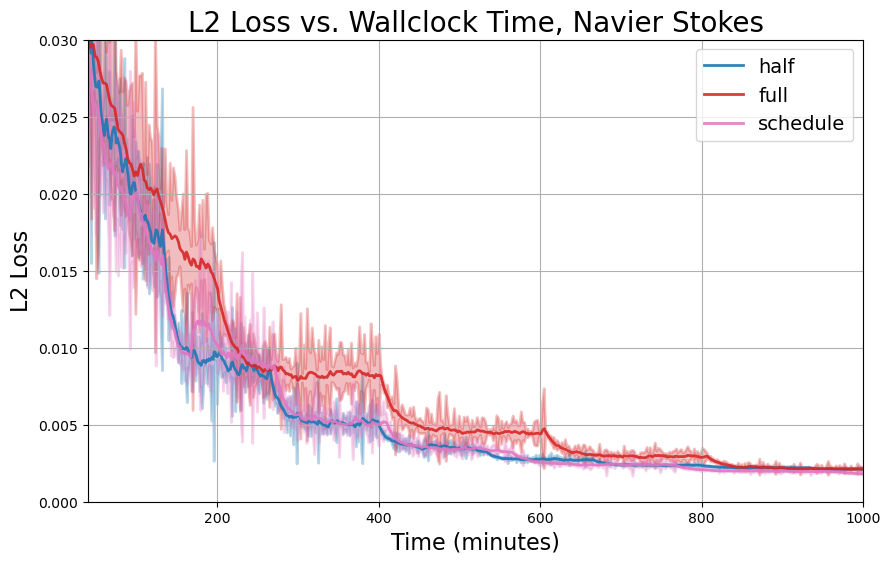

In [26]:
plot_training_curves(sorted_data, data='Navier Stokes', xlim=[40, 1000], ylim=[.003,.05], metric='128_h1')
plot_training_curves(sorted_data, data='Navier Stokes', xlim=[40, 1000], ylim=[0,.03], metric='128_l2')